In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, AgglomerativeClustering

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

# Plotting niceties
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 11

---
## 1. What is clustering?

**Clustering** is an *unsupervised* learning task: given only a collection of data points (no labels), we want to split them into groups (clusters) so that:

* points **in the same cluster** are “similar” to each other  
* points **in different clusters** are “dissimilar”

Formally, given a dataset $S = \{x_1, \dots, x_n\} \subset \mathbb{R}^m$ and a distance (or similarity) function $d(x, y)$, we want to find a partition of $S$ into disjoint subsets (clusters) $C_1, \dots, C_k$.

Typical uses include:

* grouping documents by topic
* customer segmentation based on behavior
* discovering communities in networks
* anomaly detection (points that don’t fit any cluster)

### 1.1 Why is clustering hard?

The same 2-D dataset can be clustered in multiple “reasonable” ways, e.g., grouping by x-coordinate vs y-coordinate vs some hidden nonlinear pattern.

We never know the true underlying structure, so:

* There can be many plausible clusterings.
* Relationships may be non-linear and subtle.
* Different distance measures or algorithms can give different answers.

Let’s see a simple illustration in code.



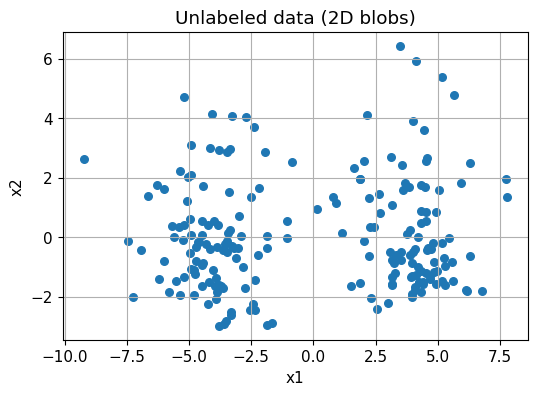

In [6]:
# Synthetic dataset where several 'reasonable' clusterings exist
X, _ = make_blobs(
    n_samples=200,
    centers=[(-4, 1), (4, 1), (-4, -1), (4, -1)],
    cluster_std=[2.0, 2.0, 1.0, 1.0],
    random_state=42
)

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=30)
ax.set_title('Unlabeled data (2D blobs)')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.show()



We can cluster this data in different plausible ways:

* By **left vs right** (x1 < 0 vs x1 ≥ 0)  
* By **up vs down** (x2 < 0 vs x2 ≥ 0)  
* Or by some diagonal / curved separation

Clustering algorithms don’t know which notion of “similarity” you care about!

### 1.2 What makes a “good” clustering?

Kleinberg (2002) proposed three intuitive properties that an ideal clustering function $f(d, S)$ should satisfy, where $d$ is a distance on $S$:

1. **Scale invariance**  
   Scaling all distances by a positive constant should not change the clustering:  
   $f(d, S) = f(\alpha d, S)$ for all $\alpha > 0$.

2. **Richness**  
   For every possible partition $\Gamma$ of $S$, there should exist some distance $d$ such that $f(d, S) = \Gamma$.

3. **Consistency**  
   If we transform distances so that  
   * within-cluster distances do not increase, and  
   * between-cluster distances do not decrease,  
   then the clustering should stay the same.

Kleinberg’s impossibility theorem: no clustering algorithm can satisfy all three properties simultaneously. Algorithms implicitly sacrifice at least one of these.

---
## 2. Agglomerative (Hierarchical) Clustering

Agglomerative clustering builds clusters **bottom-up**:

1. Start with each point in its own cluster.
2. Repeatedly merge the pair of clusters with the smallest distance.
3. Continue until everything is merged into a single cluster.

The result is a **hierarchy of clusters** (a tree), not just one partition.

A crucial ingredient: how do we define the distance between two clusters?

### 2.1 Linkage strategies

Let $C_i, C_j$ be clusters and $d(x, y)$ a point-wise distance (e.g. Euclidean).

* **Single linkage**  
  $d(C_i, C_j) = \min_{x \in C_i, y \in C_j} d(x, y)$  
  (distance between the closest pair of points).

* **Complete linkage**  
  $d(C_i, C_j) = \max_{x \in C_i, y \in C_j} d(x, y)$  
  (distance between the furthest pair of points).

* **Average linkage**  
  $d(C_i, C_j) = \frac{1}{|C_i||C_j|} \sum_{x\in C_i} \sum_{y\in C_j} d(x, y)$.

* **Ward’s method** (variance-minimizing)  
  Measures the **increase in within-cluster variance** if the two clusters were merged. It is equivalent to
  $d(C_i, C_j) = \frac{|C_i||C_j|}{|C_i| + |C_j|} \|\mu_i - \mu_j\|_2^2$,  
  where $\mu_i, \mu_j$ are centroids of each cluster.

Next we’ll see how they differ on a toy dataset.



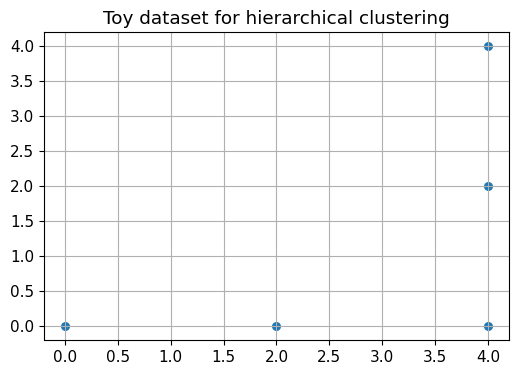

In [36]:
points = np.array([
    [0,0],   # A
    [2,0],   # B
    [4,0],   # C
    [4,2],   # D
    [4,4],   # E
])
labels_small = np.array(['A','B','C','D','E'])

fig, ax = plt.subplots()
ax.scatter(points[:, 0], points[:, 1], s=30)
ax.set_title('Toy dataset for hierarchical clustering')
plt.show()

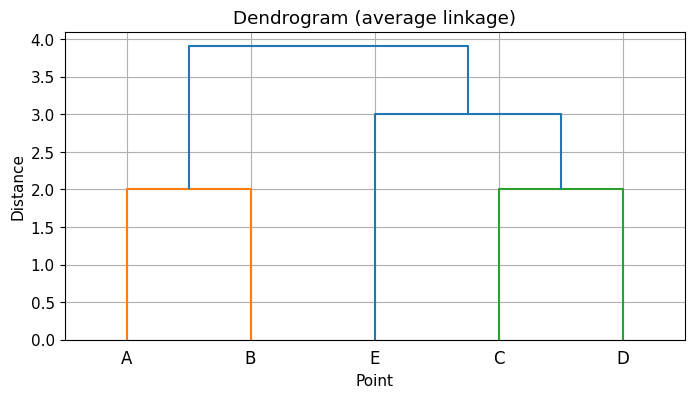

In [37]:
method = "average"
Z_small = linkage(points, method=method)
plt.figure(figsize=(8, 4))
dendrogram(Z_small, labels=labels_small)
plt.title(f'Dendrogram ({method} linkage)')
plt.xlabel('Point')
plt.ylabel('Distance')
plt.show()

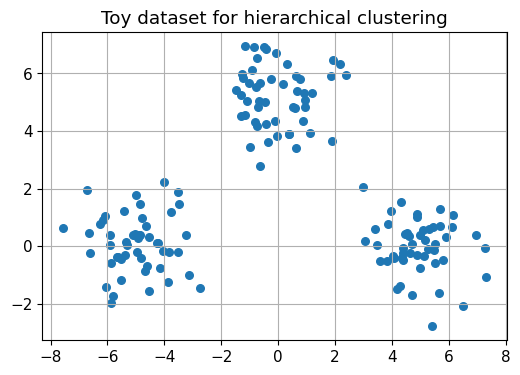

In [7]:
# Create a toy 2D dataset with three blobs
X_blobs, _ = make_blobs(
    n_samples=150,
    centers=[(-5, 0), (0, 5), (5, 0)],
    cluster_std=[1.0, 1.0, 1.0],
    random_state=0
)

fig, ax = plt.subplots()
ax.scatter(X_blobs[:, 0], X_blobs[:, 1], s=30)
ax.set_title('Toy dataset for hierarchical clustering')
plt.show()



### 2.2 Comparing linkage methods with dendrograms (via SciPy)

We will:

1. Compute the hierarchical clustering using `scipy.cluster.hierarchy.linkage`.
2. Visualize the hierarchy using a **dendrogram**.
3. Cut the dendrogram to get a flat clustering.



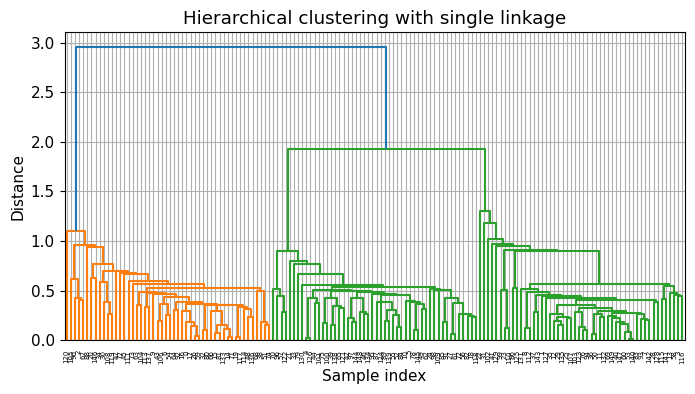

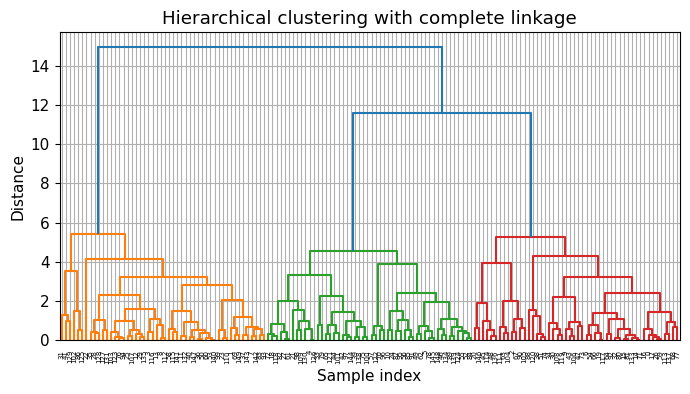

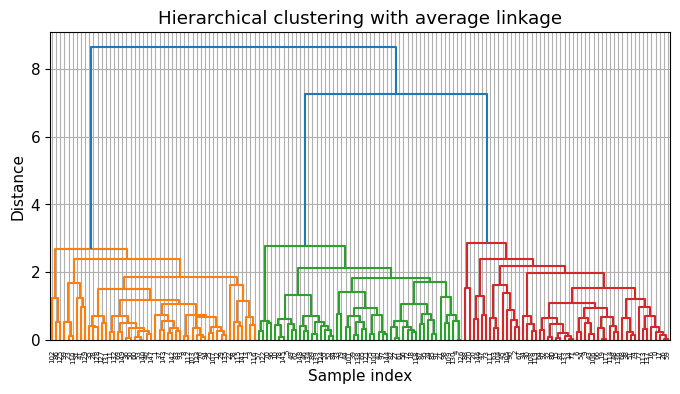

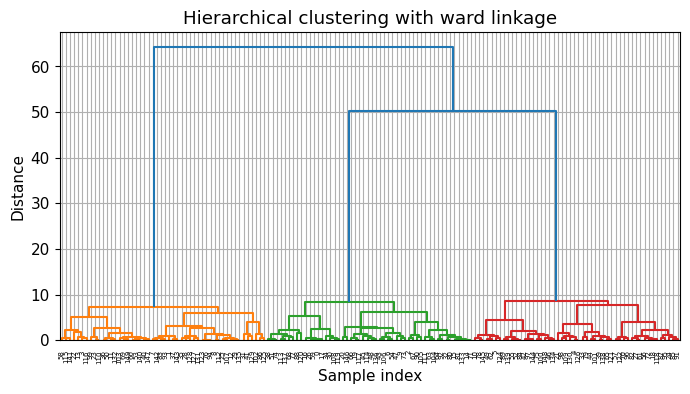

In [8]:
def plot_dendrogram(X, method='single', title=None):
    """Plot a dendrogram for dataset X using the given linkage method."""
    Z = linkage(X, method=method)
    plt.figure(figsize=(8, 4))
    dendrogram(Z)
    plt.title(title or f'Dendrogram ({method} linkage)')
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.show()
    return Z

for m in ['single', 'complete', 'average', 'ward']:
    _ = plot_dendrogram(X_blobs, method=m, title=f'Hierarchical clustering with {m} linkage')



---
## 3. Extracting flat clusters from a dendrogram

The dendrogram shows all possible merges. To get an actual clustering (a partition), we can:

* Choose a number of clusters $k$ and cut the tree at the level that leaves $k$ branches.
* Choose a distance threshold $t$ and cut where merges exceed that distance.

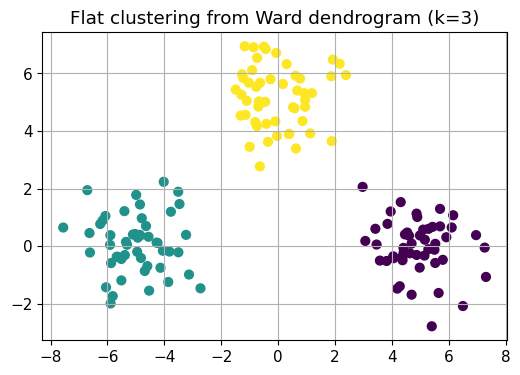

In [9]:
# cut a Ward dendrogram into k=3 clusters
Z_ward = linkage(X_blobs, method='ward')
labels_3 = fcluster(Z_ward, t=3, criterion='maxclust')

fig, ax = plt.subplots()
ax.scatter(X_blobs[:, 0], X_blobs[:, 1], c=labels_3, s=40)
ax.set_title('Flat clustering from Ward dendrogram (k=3)')
plt.show()



---
## 6. Finding a representative element of a cluster

Once we have clusters, we often want a **representative** for each cluster.

Two common choices:

* **Centroid**: the mean of all points in the cluster.
* **Medoid** (clustroid): an actual data point that is most central under the chosen distance.



In [38]:
def cluster_centroid(X_cluster):
    # Compute centroid (mean vector) of a cluster
    return X_cluster.mean(axis=0)

def cluster_medoid(X_cluster):
    # Compute medoid of a cluster using Euclidean distances
    D = squareform(pdist(X_cluster, metric='euclidean'))
    sums = D.sum(axis=1)
    idx = np.argmin(sums)
    return X_cluster[idx], idx

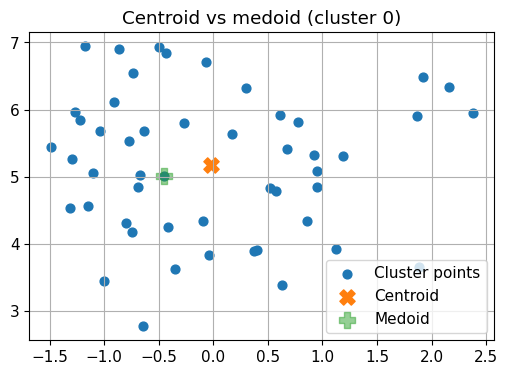

Centroid: [-0.01872153  5.18274747]
Medoid: [-0.4555325   5.01747916]


In [40]:
# Cluster blobs with k-means to get a cluster to examine
kmeans_demo = KMeans(n_clusters=3, random_state=0, n_init=10)
cluster_labels = kmeans_demo.fit_predict(X_blobs)

cluster_id = 0
X_cluster = X_blobs[cluster_labels == cluster_id]

cent = cluster_centroid(X_cluster)
med, med_idx = cluster_medoid(X_cluster)

fig, ax = plt.subplots()
ax.scatter(X_cluster[:, 0], X_cluster[:, 1], s=40, label='Cluster points')
ax.scatter(cent[0], cent[1], marker='X', s=120, label='Centroid')
ax.scatter(med[0], med[1], marker='P', s=120, label='Medoid', alpha=0.5)
ax.legend()
ax.set_title(f'Centroid vs medoid (cluster {cluster_id})')
plt.show()

print('Centroid:', cent)
print('Medoid:', med)



---
## 7. Partitioning clustering: k-means

Now we move to partitioning methods, which directly split the data into $k$ clusters without building a full hierarchy.
The most famous example is **k-means**.

### 7.1 Objective

Given a dataset $D = \{x_1, \dots, x_n\} \subset \mathbb{R}^m$ and a chosen number of clusters $k$, k-means aims to:

$$
 \min_{\mu_1, \dots, \mu_k} \sum_{i=1}^k \sum_{x \in C_i} \|x - \mu_i\|_2^2
$$

Each point is assigned to the cluster whose centroid is closest in a predefined distance (Euclidean distance in our case).



### 7.2 k-means algorithm (from scratch)

1. Initialize k centroids (e.g. randomly chosen data points).
2. **Assignment step**: assign each point to the nearest centroid.
3. **Update step**: recompute each centroid as the mean of points assigned to it.
4. Repeat 2–3 until convergence.



Converged after 11 iterations.


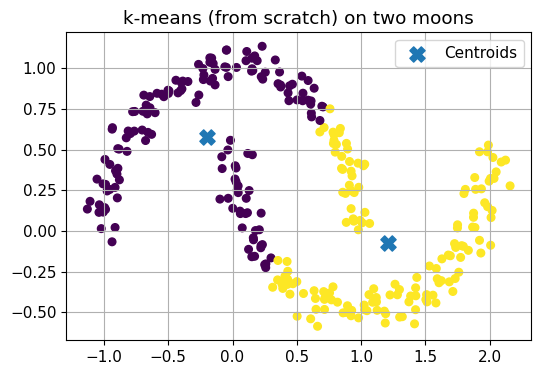

In [42]:
def kmeans_from_scratch(X, k, max_iter=100, random_state=None):
    rng = np.random.default_rng(random_state)
    n_samples, n_features = X.shape
    indices = rng.choice(n_samples, size=k, replace=False)
    centroids = X[indices].copy()
    for it in range(max_iter):
        distances = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
        labels = distances.argmin(axis=1)
        new_centroids = np.zeros_like(centroids)
        for j in range(k):
            cluster_points = X[labels == j]
            if len(cluster_points) == 0:
                new_centroids[j] = X[rng.integers(0, n_samples)]
            else:
                new_centroids[j] = cluster_points.mean(axis=0)
        if np.allclose(new_centroids, centroids):
            print(f'Converged after {it+1} iterations.')
            break
        centroids = new_centroids
    return centroids, labels

# Two-moons dataset (non-linearly separable)
X_moons, _ = make_moons(n_samples=300, noise=0.06, random_state=42)
centroids_km, labels_km = kmeans_from_scratch(X_moons, k=2, random_state=0)

fig, ax = plt.subplots()
ax.scatter(X_moons[:, 0], X_moons[:, 1], c=labels_km, s=30)
ax.scatter(centroids_km[:, 0], centroids_km[:, 1], marker='X', s=120,
           label='Centroids')
ax.set_title('k-means (from scratch) on two moons')
ax.legend()
plt.show()



Notice that k-means struggles here because the true clusters are non-convex (“two moons”),
but k-means implicitly prefers roughly spherical clusters.



### 7.4 Sensitivity to initialization

k-means can converge to different local minima depending on the initial centroids.



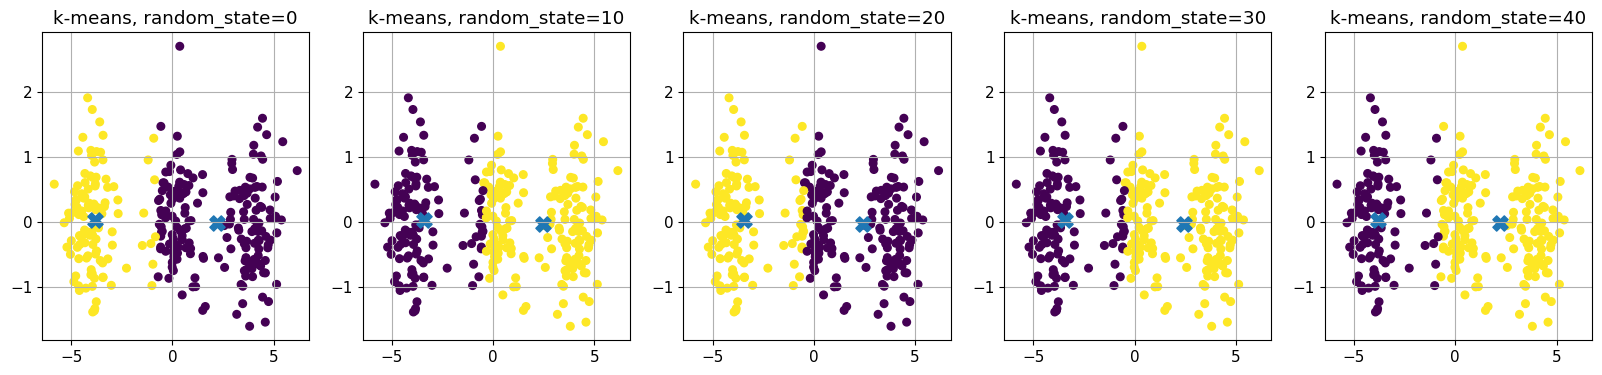

In [48]:
def run_kmeans_multiple_inits(X, k, seeds):
    fig, axes = plt.subplots(1, len(seeds), figsize=(4 * len(seeds), 4))
    if len(seeds) == 1:
        axes = [axes]
    for ax, seed in zip(axes, seeds):
        km = KMeans(n_clusters=k, random_state=seed, n_init=1, init='random')
        labels = km.fit_predict(X)
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=30)
        ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
                   marker='X', s=120)
        ax.set_title(f'k-means, random_state={seed}')
    plt.show()


Xbb, ybb_true = make_blobs(
    n_samples=300,
    centers=[(-4, 0), (0, 0), (4, 0)],  # 3 blobs in a line
    cluster_std=0.7,
    random_state=42
)

run_kmeans_multiple_inits(Xbb, k=2, seeds=[0, 10, 20, 30, 40])